In [1]:
experiment_setup_name = "musicians_category_sessions_example"

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import sys
sys.path.append("..")

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=gpu1'

import theano

import theano.tensor as T
import lasagne


env: THEANO_FLAGS='device=gpu1'


Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)
/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:

from config import snapshot_path

floatX = theano.config.floatX

from auxilary import create_shared,set_shared,_in1d
from persistence import save,load


In [5]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* two layers of GRU memory
* Qvalues predicted via dense layer from both memory layers
* epsilon-greedy decision making
* trained with Adadelta

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 393 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [8]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


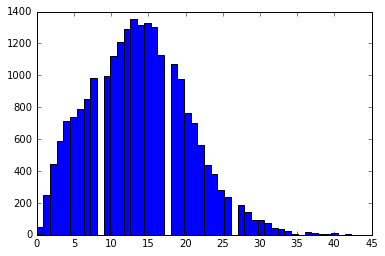

In [9]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [10]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [11]:
from sklearn.cross_validation import train_test_split

In [12]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [57]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.1,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 7734
контрольная выборка: 860


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [58]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = self._attributes.shape[0]
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32') #it is highly important to make sure 
        #that variables touched by theano.grad have float* type
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+2).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())    
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                can_do_action[:,None], #uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation
    def is_alive(self,observation_seq):
        """
        accepts observation sequence [batch,time,unit] and returns whether session is alive uint8[batch,time]
        """
        return T.eq(observation_seq[:,:,1],0)

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-1,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [59]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

In [60]:
def load_random_batch(env,attrs,cats,batch_size=10):
    """loads new data samples into environment"""
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [61]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [62]:
import lasagne
__idea__="""
 
We train two memory states:
    first one, based on observations, and second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.

"""
n_hid_1=256 #first GRU memory
n_hid_2=128 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [63]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

### подгружаем предобученную сеточку

In [64]:
load_weights = True
if load_weights:
    starting_epoch = 5000
    epoch_counter = starting_epoch+1
    pre_trained_network_experiment =  "musicians_category_multilayer_example"
    load(resolver,"/home/jheuristic/yozhik/agentnet_snapshots/{}.epoch{}.pcl".format(pre_trained_network_experiment,starting_epoch))

# Interactions with environment

In [65]:
seq_length = 20
history = agent.get_sessions(env,session_length=seq_length,
                       batch_size=env._joint_data.shape[0],)
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [66]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Session pool init and updates

In [67]:
from sessions import SessionEnvironment
session_pool = SessionEnvironment()

In [70]:
#a new batch was loaded
env.load_data_batch(train_attrs[:100],train_cats[:100])

In [69]:
#initialize the pool
initial_update_pool= session_pool.get_session_updates(observation_seq,action_seq,rewards_seq)


init_pool_fun = theano.function([],updates=initial_update_pool)
init_pool_fun()

[]

### update pool

In [71]:
#add new sessions to pool

new_observation_seq = T.concatenate([session_pool.observations,observation_seq],axis=0)
new_action_seq = T.concatenate([session_pool.actions,action_seq],axis=0)
new_rewards_seq = T.concatenate([session_pool.rewards,rewards_seq],axis=0)

extend_update_pool= session_pool.get_session_updates(new_observation_seq,new_action_seq,new_rewards_seq)

expand_pool_fun = theano.function([],updates=extend_update_pool)

In [72]:
replay_log = agent.get_sessions(session_pool,session_length=seq_length,
                       batch_size=session_pool.actions.shape[0],)


_,_,hidden_replay,qvalues_replay,untaken_actions_replay = replay_log
actions_replay = session_pool.actions
#in these sessions, states are fake single-zero placeholders, 
#observations are equal to session_pool.observations,
#untaken_actions_replay are actions that agent would want to take, but didn't
#session_pool.actions are the replayed actions


#Since actions did not change, we can use the old rewards
#TODO: add DontDoThatError to SessionEnvironment.get_reward_whatever
rewards_replay = session_pool.rewards


In [73]:
#replay Qvalues


#indicator that i-th batch is alive by j-th timestamp
is_alive_replay = env.is_alive(session_pool.observations)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)

Qpredicted_replay, Qreference_replay, is_end_replay = session_pool.get_reference(
    qvalues_replay,actions_replay,rewards_replay,
    is_alive_replay,gamma_or_gammas=gamma,)


In [74]:
#Qvalues error

squared_error = lasagne.objectives.squared_error(Qpredicted_replay,Qreference_replay)

#session mse = sum(errors_while_alive) / num_alive_ticks
replay_session_mse =  (squared_error * is_alive_replay).sum(axis=1) / T.sum(is_alive_replay,axis=1)



In [75]:
#worst N
pool_size = _shared("pool_size",250,dtype='int32')

order_by_error = T.argsort(replay_session_mse)

survived_ids = order_by_error[-pool_size:][::-1]

shrinked_observation_seq = session_pool.observations[survived_ids] 
shrinked_action_seq = session_pool.actions[survived_ids]
shrinked_rewards_seq = session_pool.rewards[survived_ids]



In [76]:
#metrics
shrinked_pool_mse = replay_session_mse[survived_ids].mean()
avg_new_reward = T.sum(rewards_seq,axis=1).mean()
avg_pool_reward = T.sum(rewards_replay,axis=1).mean()

In [77]:
from collections import OrderedDict

pool_updates = session_pool.get_session_updates(shrinked_observation_seq,shrinked_action_seq,shrinked_rewards_seq)

shrink_pool_fun = theano.function([],[shrinked_pool_mse,avg_new_reward,avg_pool_reward],updates=pool_updates)

In [78]:
def update_session_pool(new_batch_attrs,new_batch_cats,sample_size=None):
    """expands pool with new sessions and than shrinks it to pool_size"""
    if sample_size == None:
        sample_size = len(new_batch_attrs)
    load_random_batch(env,new_batch_attrs,new_batch_cats,sample_size)
    expand_pool_fun()
    return shrink_pool_fun()


### train from session pool

In [79]:
loss_mse = replay_session_mse.mean()
from lasagne.regularization import  regularize_network_params,l2
loss_l2 = lasagne.regularization.regularize_network_params(gru2,l2)*10**-5


training_loss = loss_mse + loss_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [80]:
weight_updates = lasagne.updates.adadelta(training_loss,weights,learning_rate=0.05)

In [81]:


replay_train_fun = theano.function([],[loss_mse,loss_l2],updates=weight_updates )

# training loop

In [94]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [95]:
epoch_counter = 5001
alpha = 0.1
ma_reward = 0.
ma_pool_reward = 0.


learning curves by epoch: 10000


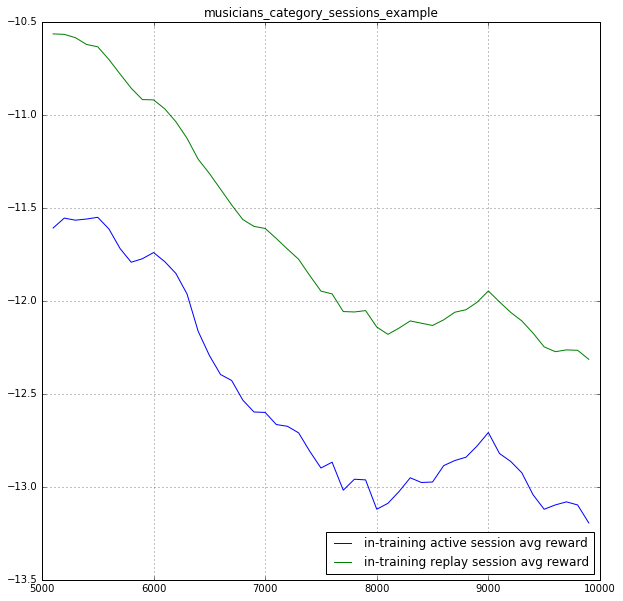

snapshot saved
epoch 10000, q-loss 6.9143, l2-loss 0.064719, greed 0.3631, rewards: ( active -12.94522, pool -12.31405)


In [ ]:
n_epochs = 100000

pool_update_size = 250

for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/50000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    loss_tuple = replay_train_fun()
    q_loss,reg_loss = map(float,loss_tuple)
    
    
    if epoch_counter %10==0:
        #update epsilon
        set_shared(resolver.epsilon,creeping_epsilon)

    if epoch_counter %100==0:

        
        #reward loss moving average
        _,avg_reward,avg_pool_reward = update_session_pool(train_attrs,train_cats,pool_update_size)
        ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
        ma_pool_reward = alpha*avg_pool_reward+ (1-alpha)*ma_pool_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "learning curves by epoch:",epoch_counter
        plot_scores(experiment_setup_name)

        
    if epoch_counter% 5000 ==0:
        save(resolver,"{}/{}.epoch{}.pcl".format(snapshot_path,experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        
        
        print "epoch %i, q-loss %.4f, l2-loss %4f, greed %.4f, rewards: ( active %.5f, pool %.5f)"%(
            epoch_counter,q_loss,reg_loss,creeping_greed,ma_reward,ma_pool_reward
        )
        
        score_log["in-training active session avg reward"][epoch_counter] = ma_reward
        score_log["in-training replay session avg reward"][epoch_counter] = ma_pool_reward
        
        


        
        
    epoch_counter  +=1

#Ой, всё!

In [89]:
ma_reward

array([ 8.15074876,  8.10147954,  7.90379139,  7.82829738,  7.77708494,
        7.70511187,  7.63015926,  7.5208143 ,  7.47116601,  7.39059932,
        7.34799955,  7.32052491,  7.27129334,  7.23726158,  7.20959514,
        7.17790905,  7.12745311,  7.0912626 ,  7.06841656,  6.99517319,
        6.97038846,  6.94619023,  6.91243318,  6.88878652,  6.88279791,
        6.87097303,  6.86016064,  6.8450387 ,  6.83185157,  6.82101899,
        6.80719009,  6.76932606,  6.75431194,  6.74910289,  6.74731373,
        6.72419092,  6.71836975,  6.68744426,  6.65791125,  6.64576249,
        6.63557188,  6.61140842,  6.58536261,  6.57055938,  6.53512944,
        6.52966502,  6.52560935,  6.52387021,  6.52295749,  6.49480347,
        6.49139532,  6.4596172 ,  6.45382409,  6.45044142,  6.44735451,
        6.44424027,  6.44350474,  6.44145927,  6.40692375,  6.40522738,
        6.36806905,  6.3666761 ,  6.36219184,  6.35627074,  6.31449806,
        6.31103755,  6.30914027,  6.30294594,  6.29951237,  6.29

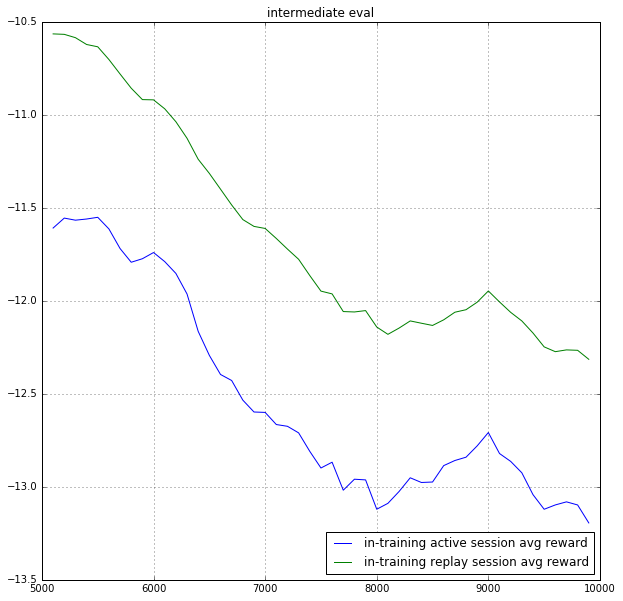

In [99]:
plot_scores("intermediate eval")

In [129]:
replay_sessions = is_end_ravel_replay.eval()

In [173]:
replay_loss

Elemwise{pow,no_inplace}.0

{20}

In [114]:
replay_mse_fun = theano.function([],[replay_loss])

In [115]:
replay_mse = replay_mse_fun()

In [122]:
top_10_worst = np.argsort(replay_mse)[-10:]
print 'worst errors:',replay_mse[top_10_worst]

worst errors: [ 29.54105377  29.54105377  29.54105377  29.54105377  29.54105377
  29.82875061  35.16474915  35.9586525   37.45066452  44.23906708]


In [138]:
action_ids_ravel_replay[top_10_worst].eval()

array([151,  88, 376,  24, 166, 115,   1, 272, 129, 106], dtype=int32)

In [141]:
np.array(feature_names)[[151,  88, 376,  24, 166, 115,   1, 272, 129, 106]]

array(['Instruments:clarinet', 'Relatives:is_known',
       'category:List_of_banjo_players', 'Genres:psychedelic',
       'decades_active:2000', 'Occupation:guitarist',
       'Birth name:is_known', 'Occupation:artist', 'Genres:southern',
       'Genres:swing'], 
      dtype='|S55')